# I will be conducting k-Means Analysis on large and smaller Canadian cities to determine how similar they are to each other

The six chosen cities and their correspondeing provinces are:
- Toronto and Peterborough (Ontario)
- Vancouver and Victoria (British Columbia)
- Montreal and Gatinuea (Quebec)

### Importing the required libraries

In [7]:
import pandas as pd
import numpy as np
import requests
from geopy.geocoders import Nominatim
#!conda install -c conda-forge folium=0.5.0 --yes #comment out after first install
import folium
import json
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans

print('Libraries imported.')

Libraries imported.


## Adding the 6 cities that will be examined today to a list

In [8]:
cities = ['Toronto, Ontario','Peterborough, Ontario','Vancouver, British Columbia','Victoria, British Columbia','Montreal, Quebec','Gatineau, Quebec'
    ]
cities.sort()
cities

['Gatineau, Quebec',
 'Montreal, Quebec',
 'Peterborough, Ontario',
 'Toronto, Ontario',
 'Vancouver, British Columbia',
 'Victoria, British Columbia']

## Getting the latitude and longitude of each city

In [9]:
columns = ['City', 'Latitude', 'Longitude']
df = pd.DataFrame(columns=columns)

for city in cities:
    address = city
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    df = df.append({'City':city, 'Latitude':latitude, 'Longitude':longitude}, ignore_index=True)

df

,City,Latitude,Longitude
0,"Gatineau, Quebec",45.428360,-75.710620
1,"Montreal, Quebec",45.497216,-73.610364
2,"Peterborough, Ontario",44.304801,-78.319950
3,"Toronto, Ontario",43.653482,-79.383935
4,"Vancouver, British Columbia",49.260872,-123.113953
5,"Victoria, British Columbia",48.428318,-123.364953


## Plotting the cities on a map

In [10]:
cities_map = folium.Map(location=[latitude,longitude], zoom_start=3)

# adding markers
for lat, lng, city in zip(df['Latitude'], df['Longitude'], df['City']):
    label = '{}'.format(city)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=10,
        popup=label,
        color='red',
        fill=True,
        fill_color='#0000FF',
        fill_opacity=0.8,
        parse_html=False).add_to(cities_map)

## Using Foursquare API to find 100 businesses per city

In [11]:
# define Foursquare credentials and version in hidden cell below

In [12]:
# The code was removed by Watson Studio for sharing.

In [13]:
# extract the venue category
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [14]:
LIMIT=100
radius=500

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # API request
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID,CLIENT_SECRET,VERSION,lat,lng,radius,LIMIT)
            
        # Get request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City', 
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [15]:
city_venues = getNearbyVenues(names=df['City'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )
print(city_venues.shape)

Gatineau, Quebec
Montreal, Quebec
Peterborough, Ontario
Toronto, Ontario
Vancouver, British Columbia
Victoria, British Columbia
(340, 7)


In [16]:
city_venues_loc = city_venues.iloc[1:]
city_venues_loc

print('There are {} unique venue categories.'.format(len(city_venues['Venue Category'].unique())))

There are 120 unique venue categories.


## Conducting One-Hot Encoding

In [17]:
cities_onehot = pd.get_dummies(city_venues[['Venue Category']], prefix = "", prefix_sep="")

cities_onehot['City'] = city_venues['City']

# group by cities

cities_grouped = cities_onehot.groupby('City').mean().reset_index()
cities_grouped

,City,American Restaurant,Art Museum,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,...,Thai Restaurant,Theater,Toy / Game Store,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store
0,"Gatineau, Quebec",0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.148148,...,0.037037,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,"Montreal, Quebec",0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,"Peterborough, Ontario",0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.020408,0.040816,0.040816,...,0.020408,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.020408,0.000000,0.000000
3,"Toronto, Ontario",0.023529,0.011765,0.000000,0.000000,0.00,0.000000,0.000000,0.011765,0.023529,...,0.011765,0.023529,0.011765,0.00,0.011765,0.011765,0.011765,0.000000,0.000000,0.011765
4,"Vancouver, British Columbia",0.013333,0.000000,0.013333,0.013333,0.00,0.026667,0.000000,0.013333,0.013333,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.013333,0.000000,0.013333,0.000000
5,"Victoria, British Columbia",0.020000,0.000000,0.000000,0.020000,0.01,0.000000,0.040000,0.000000,0.020000,...,0.020000,0.000000,0.000000,0.01,0.040000,0.000000,0.010000,0.000000,0.000000,0.000000


## Selecting the top 10 business categories for each city

In [18]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=True)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st','nd','rd']

columns = ['City']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
        
# create new dataframe
cities_venues_sorted = pd.DataFrame(columns=columns)
cities_venues_sorted['City'] = cities_grouped['City']

for ind in np.arange(cities_grouped.shape[0]):
    cities_venues_sorted.iloc[ind,1:] = return_most_common_venues(cities_grouped.iloc[ind,:], num_top_venues)
    
cities_venues_sorted

,City,1st Most Common venue,2nd Most Common venue,3rd Most Common venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Gatineau, Quebec",American Restaurant,Paper / Office Supplies Store,Outdoor Supply Store,Office,Noodle House,Nightclub,New American Restaurant,Neighborhood,Music Venue,Monument / Landmark
1,"Montreal, Quebec",American Restaurant,Pizza Place,Pharmacy,Performing Arts Venue,Park,Paper / Office Supplies Store,Outdoor Supply Store,Office,Noodle House,Nightclub
2,"Peterborough, Ontario",American Restaurant,Outdoor Supply Store,Office,Noodle House,New American Restaurant,Neighborhood,Museum,Monument / Landmark,Modern European Restaurant,Miscellaneous Shop
3,"Toronto, Ontario",Italian Restaurant,French Restaurant,Frozen Yogurt Shop,Gaming Cafe,Garden,Rock Club,Residential Building (Apartment / Condo),Greek Restaurant,Grocery Store,Record Shop
4,"Vancouver, British Columbia",Women's Store,Indonesian Restaurant,Pub,Record Shop,Hotel,History Museum,Historic Site,Hardware Store,Gym / Fitness Center,Residential Building (Apartment / Condo)
5,"Victoria, British Columbia",Women's Store,Liquor Store,Latin American Restaurant,Karaoke Bar,Jewelry Store,Sports Bar,Wine Shop,History Museum,Gym / Fitness Center,Shopping Mall


## Conducting k-Means Clustering Analysis

In [65]:
kclusters = 6

cities_grouped_clustering = cities_grouped.drop('City',1)

kmeans = KMeans(n_clusters=kclusters,random_state=0).fit(cities_grouped_clustering)

kmeans.labels_[0:6]

# add clustering labels
cities_venues_sorted.insert(1, 'Cluster Labels', kmeans.labels_)

merged_cities = cities_venues_sorted.join(df.set_index('City'), on='City')

ValueError: cannot insert Cluster Labels, already exists

## Mapping the clusters

In [21]:
venue_groups_map = folium.Map(location=[latitude, longitude], zoom_start=4)

# colour-code the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colours_array = cm.rainbow(np.linspace(0,1,len(ys)))
rainbow = [colors.rgb2hex(i) for i in colours_array]

# add markers
markers_colours = []
for lat, lon, poi, cluster in zip(merged_cities['Latitude'], merged_cities['Longitude'], merged_cities['City'], merged_cities['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
    [lat, lon],
    radius=5,
    popup=label,
    color=rainbow[cluster-1],
    fill=True,
    fill_color=rainbow[cluster-1],
    fill_opacity=0.8).add_to(venue_groups_map)
    
venue_groups_map

## Plotting the 10 most common business venues in each city

In [136]:
cluster_1 = merged_cities[merged_cities['Cluster Labels'] == 0]
cluster_2 = merged_cities[merged_cities['Cluster Labels'] == 1]
cluster_3 = merged_cities[merged_cities['Cluster Labels'] == 2]
cluster_4 = merged_cities[merged_cities['Cluster Labels'] == 3]
cluster_5 = merged_cities[merged_cities['Cluster Labels'] == 4]
cluster_6 = merged_cities[merged_cities['Cluster Labels'] == 5]

list_cluster = [cluster_1, cluster_2, cluster_3, cluster_4, cluster_5, cluster_6]
titles = list()
for k in range(6):
    lst = list(list_cluster[k].City)
    titles.append(' '.join(lst))

In [163]:
top_10_clusters = list()
for dfs in list_cluster:
    temp_list = list()
    for col in range(1, 5):
        for i in range(0, dfs.shape[0]):
            temp_list.append(dfs.iloc[i,col])
    top_10_clusters.append(temp_list)

In [164]:
from collections import Counter
df_clusters = list()
for k in range(6):
    each_cluster = Counter(top_10_clusters[k])
    temp_df = pd.DataFrame.from_dict(each_cluster, orient='index').reset_index()
    col = ['Type of Venue', 'Number of Venues']
    temp_df.columns = col
    temp_df.sort_values(by=['Number of Venues'], inplace=True)
    df_clusters.append(temp_df)

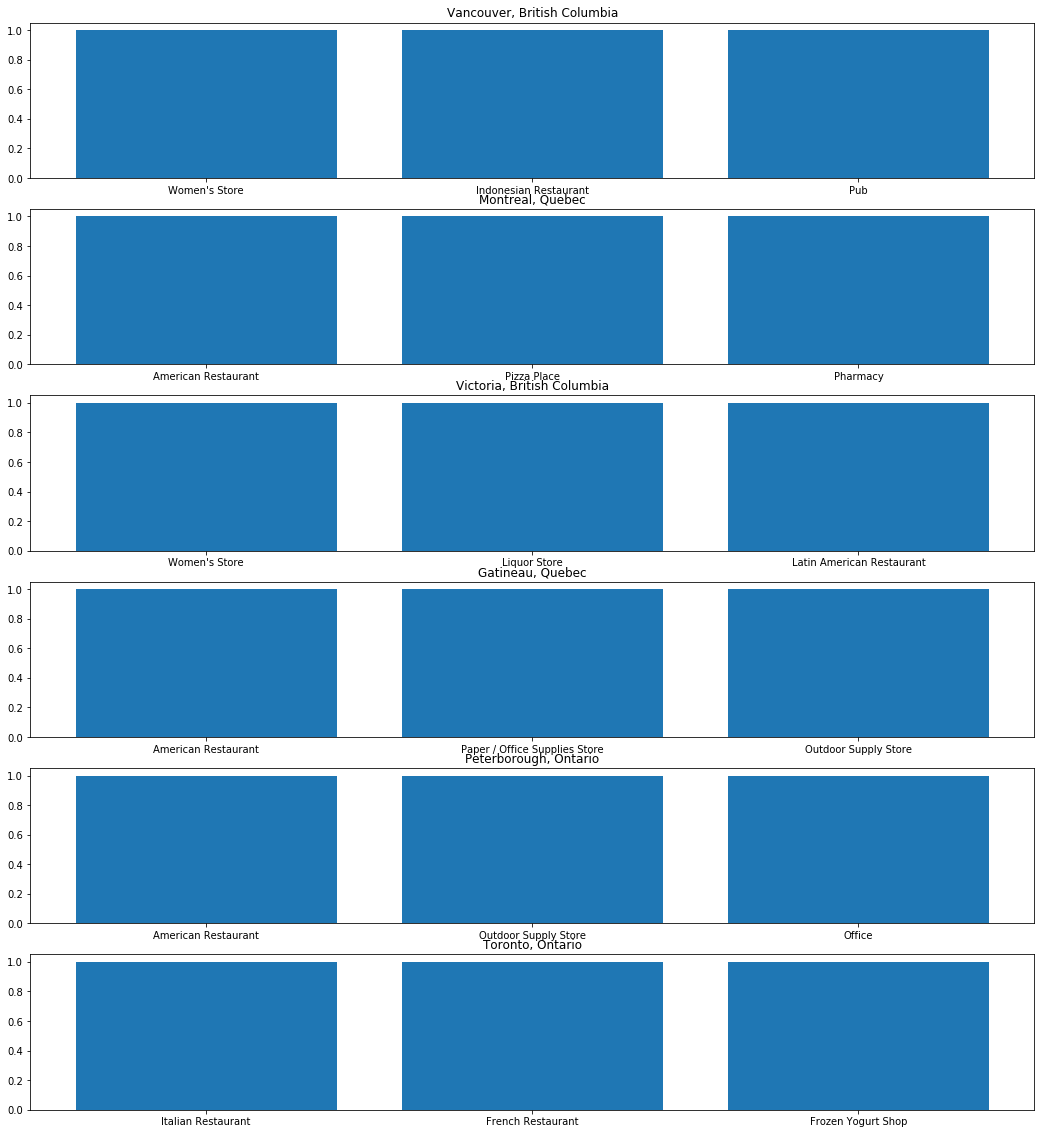

In [168]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(6, 1, figsize=(18, 20), constrained_layout=False)

for ax, k in zip(axs, range(6)):
    ax.bar(df_clusters[k].iloc[1:,0], df_clusters[k].iloc[1:,1])
    ax.set_title(titles[k])